# Fraud Detection in Electricity and Gas Consumption Challenge

This is a simple starter notebook based on the tutorial prepared by Joy Wawira. Check out the article [here](https://zindi.africa/learn/fraud-detection-in-electricity-and-gas-consumption-challenge-tutorial) for a more detailed description of the steps taken.

This notebook covers:
- Downloading the data straight from Zindi and onto colab
- Loading the data and carrying out simple EDA to understand the data and prepare for modelling 
- Preprocessing the data and feature engineering 
- Creating a simple LGBM model and predicting on the test set
- Prepare submission file and save as csv
- Some tips on how to improve model performance and your score

# Pre-Requisites

In [2]:
# DATA_DIR = '/content'
import os
DATA_DIR = os.getcwd()

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

OUTPUT_DIR = f'{DATA_DIR}/output'

In [3]:
TRAIN_DIR

'/home/login/Documents/Zindi Data Science/electricity_fraud_detection/train'

## Import Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import lightgbm
from lightgbm import LGBMClassifier
# import tensorflow as tf

import warnings
warnings.simplefilter('ignore')

## Read the Data

In [5]:
client_train = pd.read_csv(f'{TRAIN_DIR}/client_train.csv')
client_train.sample(1)

,disrict,client_id,client_catg,region,creation_date,target
28665,63,train_Client_125796,11,312,22/12/1999,0.0


The invoice train dataset was too large and caused the laptop to crash. Used the chunksize argument to read the data in chunks.

In [6]:
chunksize = 100000
invoice_train_chunks = pd.read_csv(f'{TRAIN_DIR}/invoice_train.csv', chunksize = chunksize)

for iteration, chunk in enumerate(invoice_train_chunks):
    if iteration == 0:
        invoice_train = chunk
    else:
        invoice_train = pd.concat([invoice_train, chunk], axis = 0)
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [7]:
client_test = pd.read_csv(f'{TEST_DIR}/client_test.csv')
client_test.sample(1)

,disrict,client_id,client_catg,region,creation_date
39148,62,test_Client_45230,11,309,04/11/2008


In [8]:
for iteration, test_chunks in enumerate(pd.read_csv(f'{TEST_DIR}/invoice_test.csv',
                                                    chunksize = chunksize)):
    if iteration == 0:
        invoice_test = test_chunks
    else:
        invoice_test = pd.concat([invoice_test, test_chunks], axis = 0)
invoice_test.tail(2)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
1939728,test_Client_9999,2009-07-01,11,869269,0,203,6,1,236,0,0,0,19909,20145,4,ELEC
1939729,test_Client_9999,2017-03-11,11,869269,0,203,9,1,800,282,0,0,32834,33916,4,ELEC


In [9]:
sample_submission = pd.read_csv(f'{DATA_DIR}/SampleSubmission.csv')
sample_submission.sample(1)

,client_id,target
7352,test_Client_16614,0.857746


## Data Understanding

In [10]:
#compare size of the various datasets
print(client_train.shape, invoice_train.shape, client_test.shape, invoice_test.shape)
# Expected output: (135493, 6) (4476749, 16) (58069, 5) (1939730, 16)

(135493, 6) (4476749, 16) (58069, 5) (1939730, 16)


In [11]:
#print top rows of dataset
invoice_train.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [12]:
#print top rows of dataset
client_train.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


##### Confirm that all clients in the invoice are found in the client dataset

In [13]:
len(invoice_train['client_id'].value_counts()) == client_train.shape[0]

True

In [14]:
#Get a summary for all numerical columns
# invoice_train.describe()

In [15]:
#Get a summary for all numerical columns
client_train.describe()

,disrict,client_catg,region,target
count,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,0.055841
std,3.354400,4.423761,104.207044,0.229614
min,60.000000,11.000000,101.000000,0.000000
25%,62.000000,11.000000,103.000000,0.000000
50%,62.000000,11.000000,107.000000,0.000000
75%,69.000000,11.000000,307.000000,0.000000
max,69.000000,51.000000,399.000000,1.000000


In [16]:
#Get concise information of each column in dataset
invoice_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [17]:
#Get concise information of each column in dataset
client_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [18]:
#Getting unique values on the invoice train data
for col in invoice_train.columns:
    print(f"{col} - {invoice_train[col].nunique()}")

client_id - 135493
invoice_date - 8275
tarif_type - 17
counter_number - 201893
counter_statue - 16
counter_code - 42
reading_remarque - 8
counter_coefficient - 16
consommation_level_1 - 8295
consommation_level_2 - 12576
consommation_level_3 - 2253
consommation_level_4 - 12075
old_index - 155648
new_index - 157980
months_number - 1370
counter_type - 2


In [19]:
#Getting unique values on the invoice train data
for col in client_train.columns:
    print(f"{col} - {client_train[col].nunique()}")

disrict - 4
client_id - 135493
client_catg - 3
region - 25
creation_date - 8088
target - 2


In [20]:
#check for missing values
invoice_train.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [21]:
#check for missing values
client_train.isnull().sum()

disrict          0
client_id        0
client_catg      0
region           0
creation_date    0
target           0
dtype: int64

No missing values in train set

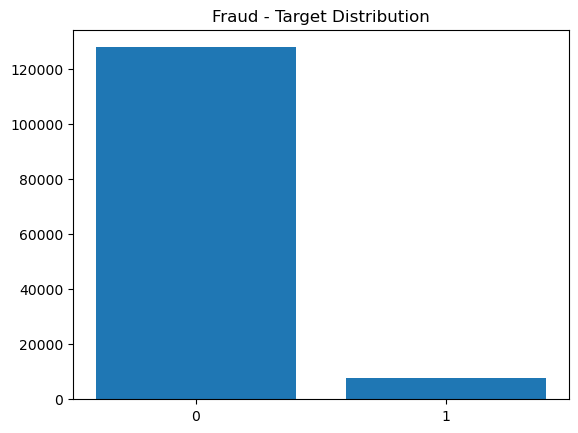

In [22]:
#Visualize fraudulent activities
fraudactivities = client_train.groupby(['target'])['client_id'].count()
plt.bar(x=fraudactivities.index, height=fraudactivities.values, tick_label = [0,1])
plt.title('Fraud - Target Distribution')
plt.show()

Target is highly imbalanced with fewer cases of fraudulent activities

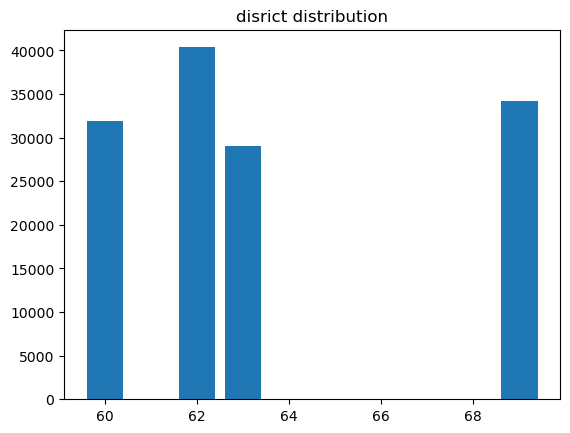

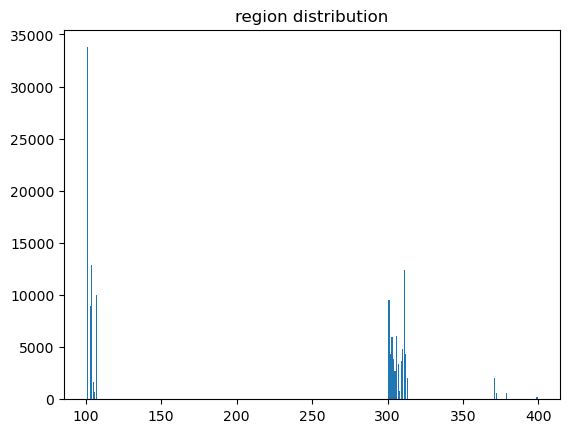

In [23]:
#Visualize client distribution across districts and regions
for col in ['disrict','region']:
    region = client_train.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
#     sns.barplot(x = region.index, y = region.values)
    plt.title(col+' distribution')
    plt.show()

In [24]:
client_train['creation_date'] = pd.to_datetime(client_train['creation_date'])
client_train['year'] = client_train['creation_date'].dt.year
client_train['month'] = client_train['creation_date'].dt.month
client_train['day'] = client_train['creation_date'].dt.day

client_test['creation_date'] = pd.to_datetime(client_test['creation_date'])
client_test['year'] = client_test['creation_date'].dt.year
client_test['month'] = client_test['creation_date'].dt.month
client_test['day'] = client_test['creation_date'].dt.day

In [25]:
client_train.sample(2)

,disrict,client_id,client_catg,region,creation_date,target,year,month,day
25566,62,train_Client_123005,11,301,2012-03-30,0.0,2012,3,30
75903,69,train_Client_46367,11,103,2010-11-10,0.0,2010,11,10


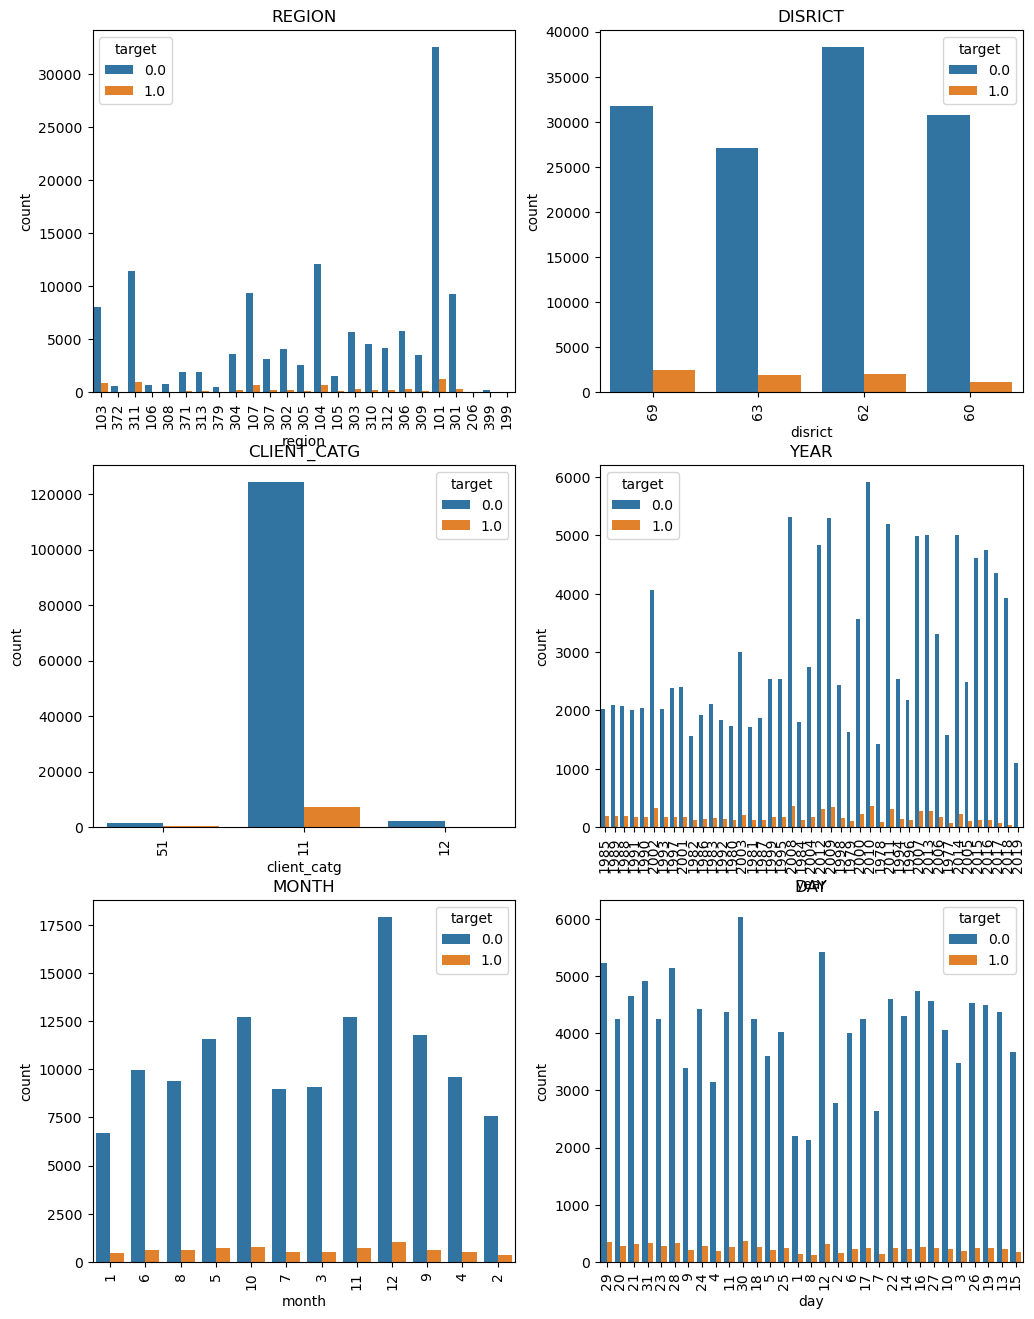

In [26]:
plt.figure(figsize= (12, 16))

for i, column in enumerate(['region', 'disrict', 'client_catg', "year", 'month', 'day']):
    plt.subplot(3, 2, i+1)
    order = client_train.groupby([column])['target'].mean()
    order = order.sort_values(ascending = False).index

    sns.countplot(data = client_train, x = column, hue = 'target', order = order)
    plt.title(column.upper())
    plt.xticks(rotation  =90)
plt.show()

In [27]:
invoice_train['counter_type'].value_counts()

ELEC    3079406
GAZ     1397343
Name: counter_type, dtype: int64

## Feature Engineering

In [28]:
#convert the column invoice_date to date time format on both the invoice train and invoice test
# also create year, month and day columns to reduce value_counts and also see if there is any correlation 

for df in [invoice_train,invoice_test]:
    df['invoice_date'] = pd.to_datetime(df['invoice_date'])
    df['year'] = df['invoice_date'].dt.year
    df['month'] = df['invoice_date'].dt.month
    df['day'] = df['invoice_date'].dt.day    

# The code above took long to execute and therefore decided to save the new datafarame as a csv file
invoice_train.to_csv("train/invoice_train.csv", index = False)
invoice_test.to_csv("test/invoice_test.csv", index = False)

In [28]:
invoice_train[['year', 'month', 'day']].sample(2)

,year,month,day
4210719,2009,1,14
2374439,2016,1,29


In [30]:
#encode labels in categorical column
d={"ELEC":0,"GAZ":1}
invoice_train['counter_type']=invoice_train['counter_type'].map(d)
invoice_test['counter_type']=invoice_test['counter_type'].map(d)

In [31]:
client_train.sample(3)

,disrict,client_id,client_catg,region,creation_date,target,year,month,day
27669,62,train_Client_1249,11,304,1995-05-19,0.0,1995,5,19
72668,60,train_Client_43455,11,101,2015-02-12,0.0,2015,2,12
104313,63,train_Client_71936,11,306,1991-05-24,0.0,1991,5,24


In [32]:
#convert categorical columns to int for model
client_train['client_catg'] = client_train['client_catg'].astype(int)
client_train['disrict'] = client_train['disrict'].astype(int)

client_test['client_catg'] = client_test['client_catg'].astype(int)
client_test['disrict'] = client_test['disrict'].astype(int)

In [33]:
invoice_train.sample(3)

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,year,month,day
1277559,train_Client_134715,2005-07-10,11,1074052,0,203,9,1,600,46,0,0,24278,24924,2,0,2005,7,10
3506606,train_Client_73723,2016-11-05,40,18723,0,5,6,1,160,0,0,0,7360,7520,4,1,2016,11,5
4109175,train_Client_89981,2016-09-09,40,4903457,0,5,9,1,56,0,0,0,29,85,4,1,2016,9,9


In [36]:
invoice_train.groupby(['client_id']).mean()

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,year,month,day
client_id,,,,,,,,,,,,,,,,
train_Client_0,11.000000,1.335667e+06,203.685714,6.971429,1.0,352.400000,10.571429,0.000000,0.000000,9444.542857,9807.514286,4.628571,0.000000,2011.142857,6.685714,21.228571
train_Client_1,11.000000,6.789020e+05,203.000000,7.216216,1.0,557.540541,0.000000,0.000000,0.000000,14330.756757,14888.297297,4.324324,0.000000,2011.837838,5.135135,14.594595
train_Client_10,11.000000,5.727650e+05,203.222222,7.055556,1.0,798.611111,37.888889,0.000000,0.000000,32873.000000,33709.500000,6.444444,0.000000,2010.944444,6.611111,12.333333
train_Client_100,11.000000,2.078000e+03,413.000000,6.150000,1.0,1.200000,0.000000,0.000000,0.000000,94.150000,95.350000,4.200000,0.000000,2008.600000,5.550000,16.350000
train_Client_1000,11.000000,1.957500e+04,207.000000,8.857143,1.0,663.714286,104.857143,117.357143,36.714286,6900.428571,7823.071429,3.714286,0.000000,2016.857143,7.571429,8.071429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
train_Client_99995,24.887324,5.423355e+05,110.267606,6.000000,1.0,1.957746,0.000000,0.000000,0.000000,7.295775,7.295775,4.225352,0.478873,2012.563380,6.042254,22.577465
train_Client_99996,25.853659,1.837554e+06,103.536585,8.487805,1.0,185.853659,0.756098,0.000000,0.000000,1216.780488,1403.390244,3.902439,0.512195,2015.829268,6.048780,16.292683
train_Client_99997,22.277778,1.602303e+05,128.444444,9.000000,1.0,273.083333,0.000000,0.000000,0.000000,2533.388889,2806.472222,4.111111,0.388889,2014.694444,6.888889,10.611111


In [58]:
def aggregate_by_client_id(invoice_data):
    aggs = {}
    aggs['consommation_level_1'] = ['mean']
    aggs['consommation_level_2'] = ['mean']
    aggs['consommation_level_3'] = ['mean']
    aggs['consommation_level_4'] = ['mean']
    # find the mean of each client for the given columns
    agg_trans = invoice_data.groupby(['client_id']).agg(aggs)
    # Rename the columns to include "_mean" at the end
    # agg_trans.columns.values returns [('consommation_level_1', 'mean') ('consommation_level_2', 'mean') ('consommation_level_3', 'mean') ('consommation_level_4', 'mean')]
    agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
    # Indices instead of client_id is used as pivot column
    agg_trans.reset_index(inplace=True)
    # create a new column which holds the value_counts for each client_id
    df = (invoice_data.groupby('client_id')
            .size()
            .reset_index(name='{}transactions_count'.format('1')))
    return pd.merge(df, agg_trans, on='client_id', how='left')

In [62]:
#group invoice data by client_id
agg_train = aggregate_by_client_id(invoice_train)

In [63]:
print(agg_train.shape)
agg_train.head()

(135493, 6)


,client_id,1transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean
0,train_Client_0,35,352.400000,10.571429,0.000000,0.000000
1,train_Client_1,37,557.540541,0.000000,0.000000,0.000000
2,train_Client_10,18,798.611111,37.888889,0.000000,0.000000
3,train_Client_100,20,1.200000,0.000000,0.000000,0.000000
4,train_Client_1000,14,663.714286,104.857143,117.357143,36.714286


In [64]:
#merge aggregate data with client dataset
train = pd.merge(client_train,agg_train, on='client_id', how='left')

In [65]:
#aggregate test set
agg_test = aggregate_by_client_id(invoice_test)
test = pd.merge(client_test,agg_test, on='client_id', how='left')

In [66]:
train.shape, test.shape

((135493, 14), (58069, 13))

In [67]:
#drop redundant columns
sub_client_id = test['client_id']
drop_columns = ['client_id', 'creation_date']

for col in drop_columns:
    if col in train.columns:
        train.drop([col], axis=1, inplace=True)
    if col in test.columns:
        test.drop([col], axis=1, inplace=True)

# Modelling

## Train LGBM *Classifier*

In [68]:
x_train = train.drop(columns=['target'])
y_train = train['target']

In [70]:
model = LGBMClassifier(boosting_type='gbdt', num_iterations=500)
model.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 7566, number of negative: 127927
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1385
[LightGBM] [Info] Number of data points in the train set: 135493, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.055841 -> initscore=-2.827795
[LightGBM] [Info] Start training from score -2.827795


LGBMClassifier(num_iterations=500)

In [71]:
x_train.disrict.unique()

array([60, 69, 62, 63])

## Make Predictions on test set

In [72]:
test.columns

Index(['disrict', 'client_catg', 'region', 'year', 'month', 'day',
       '1transactions_count', 'consommation_level_1_mean',
       'consommation_level_2_mean', 'consommation_level_3_mean',
       'consommation_level_4_mean'],
      dtype='object')

In [73]:
preds = model.predict(test)
preds = pd.DataFrame(preds, columns=['target'])
preds.head()

,target
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [74]:
submission = pd.DataFrame(
    {
        'client_id': sub_client_id,
        'target': preds['target']
    }
)

submission.head()

,client_id,target
0,test_Client_0,0.0
1,test_Client_1,0.0
2,test_Client_10,0.0
3,test_Client_100,0.0
4,test_Client_1000,0.0


In [75]:
submission.to_csv(f'{OUTPUT_DIR}/submission.csv', index=False)

## Tips 
- Thorough EDA and incorporating domain knowledge
- Re-grouping categorical features
- More feature engineering(try utilizing some date-time features)
- Target balancing - oversampling, undersampling, SMOTE, scale_pos_weight
- Model ensembling
- Train-test split or cross-validation


# ******************* GOOD LUCK!!! ***************************